# First Neural ODE example

A neural ODE is an ODE where a neural network defines its derivative function. $\dot{u} = NN(u)$

From: https://docs.sciml.ai/DiffEqFlux/stable/examples/neural_ode/

In [1]:
using Lux, DiffEqFlux, OrdinaryDiffEq, ComponentArrays
using Optimization, OptimizationOptimJL, OptimizationOptimisers
using Random, Plots
rng = Random.Xoshiro(0)

Random.Xoshiro(0xdb2fa90498613fdf, 0x48d73dc42d195740, 0x8c49bc52dc8a77ea, 0x1911b814c02405e8, 0x22a21880af5dc689)

True solution: $u^3$ and multiplied by a matrix

In [2]:
function trueODEfunc(du, u, p, t)
    true_A = [-0.1 2.0; -2.0 -0.1]
    du .= ((u.^3)'true_A)'
end

trueODEfunc (generic function with 1 method)

Generate data from the true function

In [3]:
u0 = [2.0; 0.0]
datasize = 31
tspan = (0.0, 1.5)
tsteps = range(tspan[begin], tspan[end], length = datasize)
prob_trueode = ODEProblem(trueODEfunc, u0, tspan)
ode_data = Array(solve(prob_trueode, Tsit5(), saveat = tsteps))

2×31 Matrix{Float64}:
 2.0  1.94946   1.76453  1.29973  0.666824  …  1.40811  1.36939   1.28907
 0.0  0.773427  1.4286   1.79062  1.86579      0.48727  0.755306  0.98924

Define a `NeuralODE` problem with a neural network from `Lux.jl`.

In [4]:
dudt2 = Lux.Chain(
    x -> x.^3,
    Lux.Dense(2, 50, tanh),
    Lux.Dense(50, 2)
)

p, st = Lux.setup(rng, dudt2) |> f64
prob_neuralode = NeuralODE(dudt2, tspan, Tsit5(), saveat = tsteps)

NeuralODE(
    model = Chain(
        layer_1 = WrappedFunction(#1),
        layer_2 = Dense(2 => 50, tanh),  # 150 parameters
        layer_3 = Dense(50 => 2),       # 102 parameters
    ),
)         # Total: 252 parameters,
          #        plus 0 states.

Predicted output

In [5]:
predict_neuralode(p) = Array(prob_neuralode(u0, p, st)[1])

predict_neuralode (generic function with 1 method)

Loss function
Optimization.jl v4 only accept a scalar output

In [6]:
function loss_neuralode(p)
    pred = predict_neuralode(p)
    l2loss = sum(abs2, ode_data .- pred)
    return l2loss
end

loss_neuralode (generic function with 1 method)

Callback function

In [7]:
anim = Animation()
lossrecord=Float64[]
callback = function (state, l; doplot = true)
    if doplot
        pred = predict_neuralode(state.u)
        plt = scatter(tsteps, ode_data[1,:], label = "data")
        scatter!(plt, tsteps, pred[1,:], label = "prediction")
        frame(anim)
        push!(lossrecord, l)
    else
        println(l)
    end
    return false
end

#3 (generic function with 1 method)

Try the callback function to see if it works.

In [8]:
pinit = ComponentArray(p)
callback((; u = pinit), loss_neuralode(pinit); doplot=false)

120.03290214006641


false

Use https://github.com/SciML/Optimization.jl to solve the problem and https://github.com/FluxML/Zygote.jl for automatic differentiation (AD).

In [9]:
adtype = Optimization.AutoZygote()

ADTypes.AutoZygote()

Define a [function](https://docs.sciml.ai/Optimization/stable/API/optimization_function/) to optimize with AD.

In [10]:
optf = Optimization.OptimizationFunction((x, p) -> loss_neuralode(x), adtype)

(::SciMLBase.OptimizationFunction{true, ADTypes.AutoZygote, Main.var"##232".var"#6#7", Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}) (generic function with 1 method)

Define an `OptimizationProblem`

In [11]:
optprob = Optimization.OptimizationProblem(optf, pinit)

OptimizationProblem. In-place: true
u0: ComponentVector{Float64}(layer_1 = Float64[], layer_2 = (weight = [-1.8019577264785767 1.509717345237732; -0.18273845314979553 -0.46764108538627625; … ; 0.37099915742874146 -0.27108314633369446; -0.34856587648391724 -0.6062840819358826], bias = [-0.5224840044975281, -0.6805992722511292, -0.21060703694820404, 0.5093754529953003, 0.336392879486084, 0.22010256350040436, -0.12450861930847168, 0.38843590021133423, 0.5799375176429749, 0.3984285593032837  …  0.10401319712400436, 0.009969078004360199, -0.460673987865448, 0.210310161113739, 0.5280858278274536, 0.7054404020309448, 0.0009628869011066854, 0.4056747257709503, 0.30830612778663635, 0.17590543627738953]), layer_3 = (weight = [0.22905384004116058 -0.23547108471393585 … 0.0332123264670372 0.13550478219985962; 0.22466984391212463 -0.148941770195961 … -0.1966829150915146 0.10960526019334793], bias = [-0.02694704197347164, -0.03700210154056549]))

Solve the `OptimizationProblem` using the ADAM optimizer first to get a rough estimate.

In [12]:
result_neuralode = Optimization.solve(
    optprob,
    OptimizationOptimisers.Adam(0.05),
    callback = callback,
    maxiters = 300
)

println("Loss is: ", loss_neuralode(result_neuralode.u))

Loss is: 0.08674469523368229


Use another optimizer (BFGS) to refine the solution.

In [13]:
optprob2 = remake(optprob; u0 = result_neuralode.u)

result_neuralode2 = Optimization.solve(
    optprob2,
    Optim.BFGS(; initial_stepnorm = 0.01),
    callback = callback,
    allow_f_increases = false
)

println("Loss is: ", loss_neuralode(result_neuralode2.u))

Loss is: 0.009647969862306089


Visualize the fitting process

In [14]:
mp4(anim, fps=15)

[ Info: Saved animation to /home/runner/work/jl-pde/jl-pde/.cache/docs/tmp.mp4


Plots.AnimatedGif("/home/runner/work/jl-pde/jl-pde/.cache/docs/tmp.mp4")

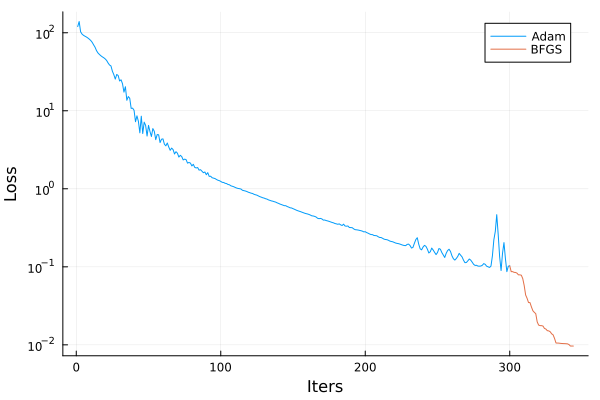

In [15]:
lossrecord
plot(lossrecord[1:300], xlabel="Iters", ylabel="Loss", lab="Adam", yscale=:log10)
plot!(300:length(lossrecord), lossrecord[300:end], lab="BFGS")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*